In [1]:
import torch
import os
import numpy as np
#import cv2
from model import monomodel
from dataset import Kittiset
from transforms import image_transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [22]:
print(torch.cuda.is_available())
torch.cuda.empty_cache()

True


torch.FloatTensor


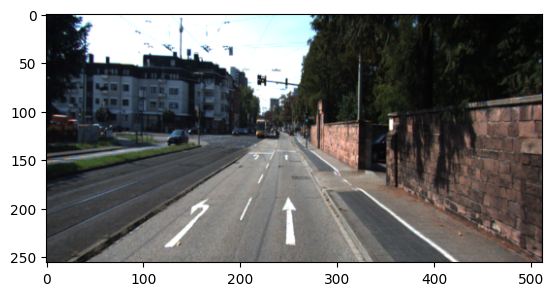

In [31]:
ckptroot = './outs/best.pth'
dataroot = 'E:/dataset/KITTI/raw/'
testset = Kittiset(data_root=dataroot, mode= 'test', transform= image_transforms(mode= 'test'),)
testloader = DataLoader(testset, batch_size= 1, shuffle= False, num_workers= 1)
imgstack = testset.__getitem__(0)
leftimg = imgstack[0,:,:,:]
print(leftimg.type())
flipleftimg = imgstack[1,:,:,:]
leftimg = np.array(leftimg).transpose(1,2,0)
flipleftimg = np.array(flipleftimg).transpose(1,2,0)

plt.imshow(leftimg)
# plt.imshow(flipleftimg)
plt.show()
# cv2.imshow('leftimg', leftimg)
# cv2.waitKey()
# cv2.imshow()

In [32]:
m = monomodel()
m.load_state_dict(torch.load(ckptroot))
m.eval()

monomodel(
  (convblock1): convblock(
    (conv1): conv(
      (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): conv(
      (conv): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (convblock2): convblock(
    (conv1): conv(
      (conv): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): conv(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (convblock3): convblock(
    (conv1): conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [33]:
disparities = np.zeros((len(testloader), 256, 512), dtype= np.float32)
disparitiesPP = disparities
from train import post_process_disparity
with torch.no_grad():
    for i , data in enumerate(testloader):
        data = data
        # print(data.size()) --> torch.Size([1, 2, 3, 256, 512])
        data = data.squeeze()
        # print(data.size()) #--> torch.Size([2, 3, 256, 512])
        disps = m(data) # 4 scales disps
        disp = disps[0][:, 0, :, :].unsqueeze(1)
        # print(disp.size()) --> torch.Size([2, 1, 256, 512])
        disparities[i] = disp[0].squeeze().cpu().numpy()
        disparitiesPP[i] = post_process_disparity(disps[0][:, 0, :, :].cpu().numpy())
        
np.save('./outs' + '/disparities.npy', disparities)
np.save('./outs' + '/disparitiesPP.npy', disparitiesPP)        

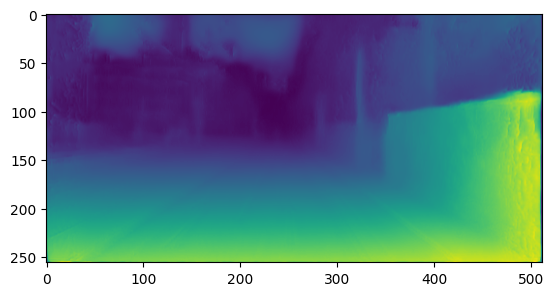

In [38]:
leftdisp = disparities[0]
#print(leftdisp.shape)
plt.imshow(leftdisp)
plt.show()

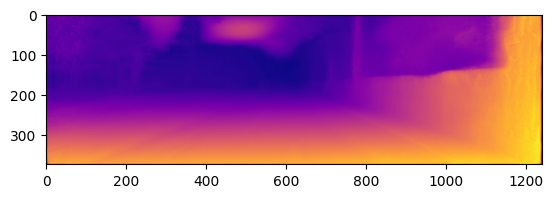

In [39]:
import skimage
disp_to_img = skimage.transform.resize(disparitiesPP[1].squeeze(), [375, 1242], mode='constant')
plt.imshow(disp_to_img, cmap='plasma')

In [40]:
# gt from velodyne_points
from utils import load_velodyne_points, generate_depth_map
velodlist = []
with open('./eigen_full/test_files.txt', 'r') as f:
    for line in f.readlines():
        velodlist.append(line)
    f.close

gt_depths = []
for i in range(len(velodlist)):
    file, name, _ = velodlist[i].split(' ')
    velodpath = dataroot + file + '/velodyne_points/data/{:010d}.bin'.format(int(name))
    #print(velodpath)
    date1, date2 = file.split('/')
    calib_dir= dataroot + date1 
    #print(calib_dir)
    depth = generate_depth_map(calib_dir=calib_dir, velo_filename= velodpath).astype(np.float32)
    gt_depths.append(depth)

    # plt.imshow(depth,cmap= 'plasma')
    # plt.show()
    # break
    

In [47]:
# convert disp to depth
width_to_focal = dict()
width_to_focal[1242] = 721.5377
width_to_focal[1241] = 718.856
width_to_focal[1224] = 707.0493
width_to_focal[1238] = 718.3351
width_to_focal[1226] = 708.2046
import cv2
pred = []
for i in range(len(velodlist)):
    gt = gt_depths[i]
    
    height, width = gt.shape
    pred_disp = disparitiesPP[i]
    pred_disp = width * cv2.resize(pred_disp, (width, height), interpolation=cv2.INTER_LINEAR)
    pred_depth = width_to_focal[width] * 0.54 / pred_disp
    pred.append(pred_depth) 
    
    if pred_depth.shape[0] != 375:
        print(pred_depth.shape)

(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(370, 1224)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(374, 1238)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370, 1226)
(370

In [50]:
from utils import compute_errors
rms     = np.zeros(697, np.float32)
log_rms = np.zeros(697, np.float32)
abs_rel = np.zeros(697, np.float32)
sq_rel  = np.zeros(697, np.float32)
d1_all  = np.zeros(697, np.float32)
a1      = np.zeros(697, np.float32)
a2      = np.zeros(697, np.float32)
a3      = np.zeros(697, np.float32)

# compute the metrics
max = 80
min = 0
for i in range(len(velodlist)):
    gt = gt_depths[i]
    pd = pred[i]

    pd[pd < min] = min
    pd[pd > max] = max
    gt_height, gt_width = gt.shape
    mask = np.logical_and(gt > min, gt < max)
    crop = np.array([0.3324324 * gt_height,  0.91351351 * gt_height,   
                                     0.0359477 * gt_width,   0.96405229 * gt_width]).astype(np.int32)
    crop_mask = np.zeros(mask.shape)
    crop_mask[crop[0]:crop[1],crop[2]:crop[3]] = 1
    mask = np.logical_and(mask, crop_mask)

    abs_rel[i], sq_rel[i], rms[i], log_rms[i], a1[i], a2[i], a3[i] = compute_errors(gt[mask], pd[mask])

print("{:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}, {:>10}".format('abs_rel', 'sq_rel', 'rms', 'log_rms', 'a1', 'a2', 'a3'))
print("{:10.4f}, {:10.4f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}, {:10.3f}".format(abs_rel.mean(), sq_rel.mean(), rms.mean(), log_rms.mean(), a1.mean(), a2.mean(), a3.mean()))


   abs_rel,     sq_rel,        rms,    log_rms,         a1,         a2,         a3
    0.1536,     1.5622,      6.102,      0.247,      0.798,      0.923,      0.965
